In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import sklearn
import plotly
data = pd.read_csv(r'C:\Users\hp\OneDrive - yncréa\Documents\One Drive - Uchiwa\OneDrive\Desktop\Cours ISEN\Projet_BigData\Fonctionnalite_number_2\export_clean_IA.csv')
interesting_columns =['SOG','COG','Heading', 'LON', 'LAT']
data_clustering = data[interesting_columns].copy()
#Vérifier que les colonnes sont numériques
for col in data_clustering.columns:
    if data_clustering[col].dtype == 'object':
        try:
            data_clustering[col] = pd.to_numeric(data_clustering[col], errors='raise')
        except ValueError:
            print(f"Colonne {col} n'est pas numérique, conversion en float64.")

print("\nDonnées pour le clustering :")
print(data_clustering.head())
print("\nTypes de données pour le clustering :")
print(data_clustering.info())
print("\nNouvelles dimensions du DataFrame pour le clustering :", data_clustering.shape)    


Données pour le clustering :
    SOG    COG  Heading       LON       LAT
0  13.4  227.6      227 -89.29958  29.07019
1   0.0    0.0        0 -89.97235  29.25456
2   7.1   51.4      511 -92.20613  29.75368
3   0.0    0.0        0 -82.63027  27.77637
4  11.3  333.1      511 -94.77660  29.33010

Types de données pour le clustering :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289411 entries, 0 to 289410
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   SOG      289411 non-null  float64
 1   COG      289411 non-null  float64
 2   Heading  289411 non-null  int64  
 3   LON      289411 non-null  float64
 4   LAT      289411 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 11.0 MB
None

Nouvelles dimensions du DataFrame pour le clustering : (289411, 5)


Apprentissage non-supervisé

# 1. METHODE KMEANS

Dans un premier temps nous allons déterminer la valeur de k optimale

-----------------------------------------
Alogorithme KMeans
-----------------------------------------



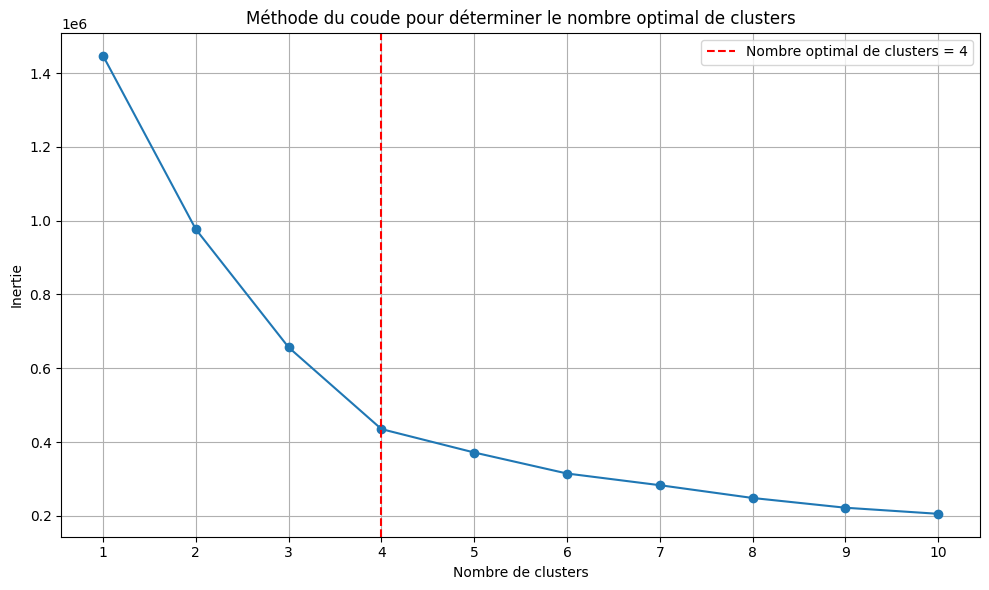

In [7]:
#Nous utiliserons l'algorithme KMeans pour le clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
print("-----------------------------------------") 
print("Alogorithme KMeans") 
print("-----------------------------------------\n")
#Mise à l'échelle des données
scaler = preprocessing.StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_clustering), columns=interesting_columns)
#Détermination du nombre optimal de clusters avec la méthode du coude
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
# Affichage de la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.xticks(range(1, 11))
plt.grid(True)
plt.axvline(x=4, color='r', linestyle='--', label='Nombre optimal de clusters = 4')
plt.legend()
plt.tight_layout()
plt.savefig('elbow_method.png')
plt.show()

D'où le K optimal dans notre cas est la valeur K = 4


Application de l'algorithme K-Means avec 4 clusters...

    SOG    COG  Heading       LON       LAT  Cluster
0  13.4  227.6      227 -89.29958  29.07019        0
1   0.0    0.0        0 -89.97235  29.25456        1
2   7.1   51.4      511 -92.20613  29.75368        0
3   0.0    0.0        0 -82.63027  27.77637        2
4  11.3  333.1      511 -94.77660  29.33010        0

Analyse des résultats du clustering :
                SOG         COG     Heading        LON        LAT
Cluster                                                          
0          7.755435  234.683017  290.740370 -91.688352  28.973802
1          1.270382   13.408663   12.608886 -92.795103  29.297154
2          6.090492  105.445482  101.899194 -80.848719  26.059065
3        102.300000  360.000000  510.896348 -91.096333  29.689839

Taille des clusters :
0     82140
1    150657
2     51713
3      4901
Name: Cluster, dtype: int64


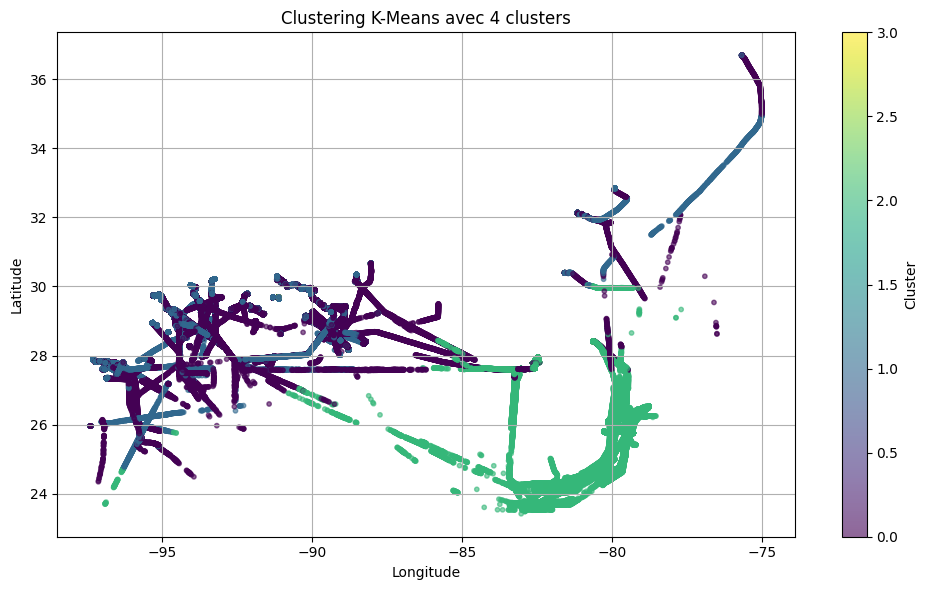

In [21]:
n_clusters = 4
print(f"\nApplication de l'algorithme K-Means avec {n_clusters} clusters...\n")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_scaled)
data_clustering['Cluster'] = kmeans.labels_
print(data_clustering.head())
#Analyse des résultats du clustering
print("\nAnalyse des résultats du clustering :")
cluster_summary = data_clustering.groupby('Cluster').mean()
print(cluster_summary)
# Affichage de la taille des clusters
print("\nTaille des clusters :")
print(data_clustering['Cluster'].value_counts().sort_index())
# Affichage des résultats du clustering
plt.figure(figsize=(10, 6))
plt.scatter(data_clustering['LON'], data_clustering['LAT'], c=data_clustering['Cluster'], cmap='viridis', marker='o', s=10, alpha=0.6)
plt.title(f'Clustering K-Means avec {n_clusters} clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('kmeans_clustering.png')
plt.show()


Distribution des autres caractéristiques

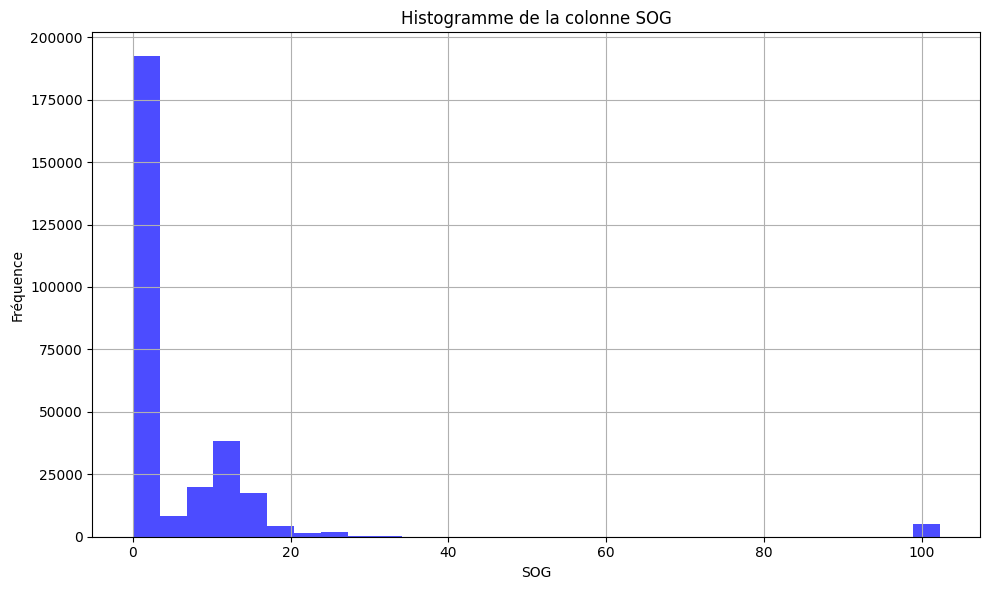

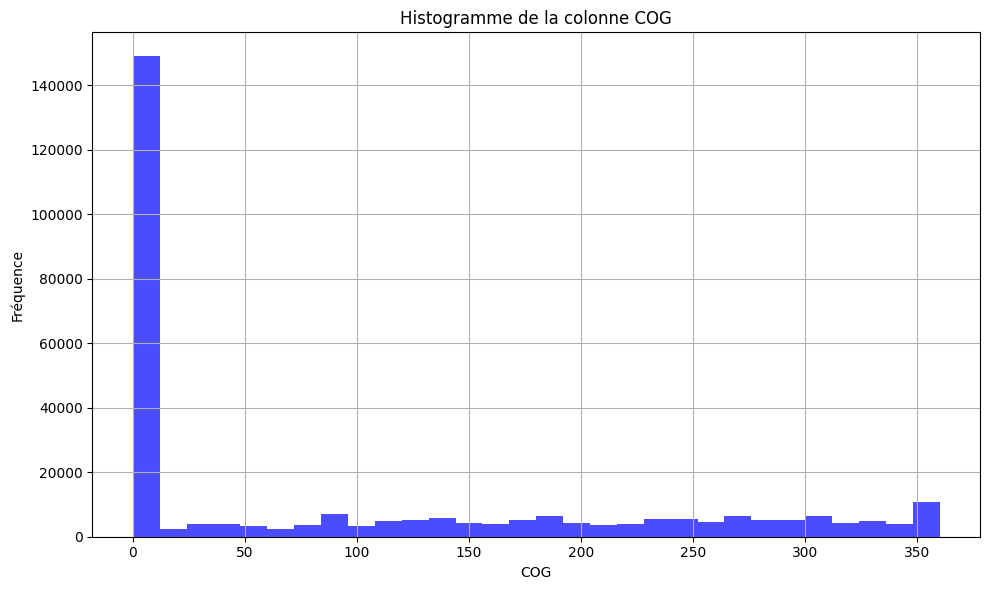

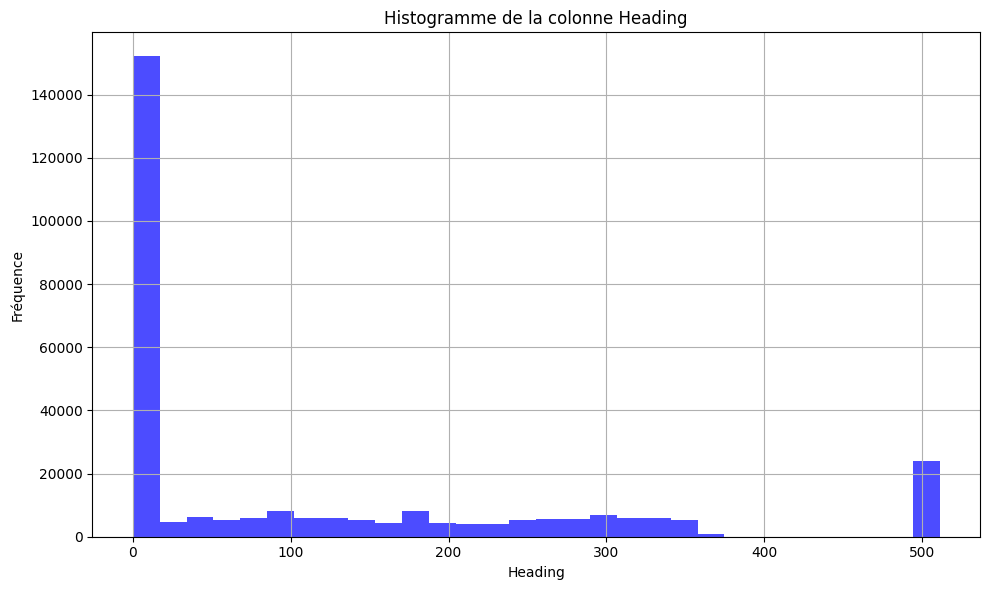

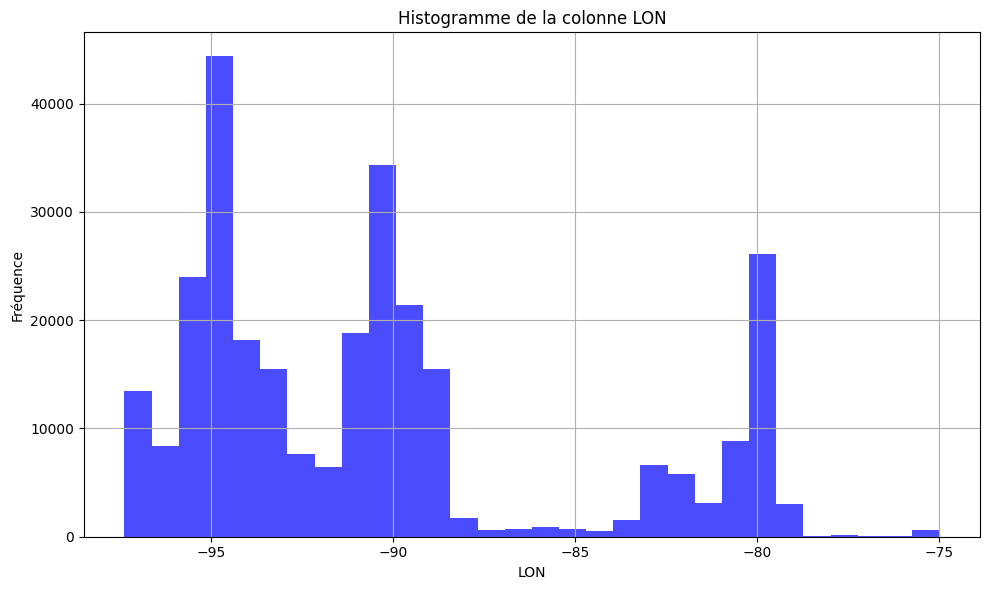

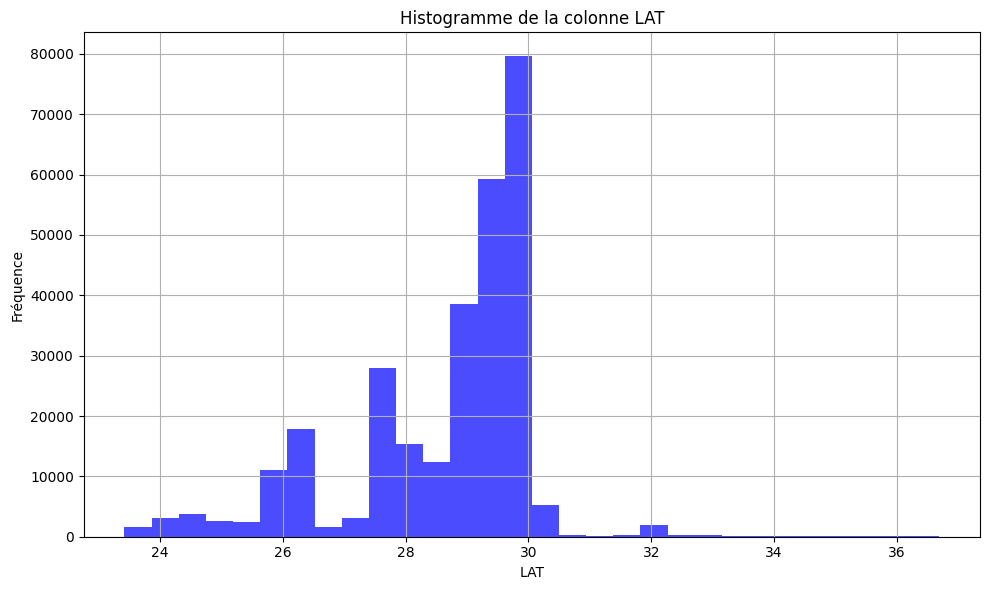

In [14]:
for col in interesting_columns:
    plt.figure(figsize=(10, 6))
    plt.hist(data_clustering[col], bins=30, alpha=0.7, color='blue')
    plt.title(f'Histogramme de la colonne {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'histogram_{col}.png')
    plt.show()

# 2. METHODE DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import seaborn as sns
min_samples = 5*2  # Minimum number of samples for a cluster
print(f"\nApplication de l'algorithme DBSCAN avec min_samples={min_samples}...\n")
# Calcul de la distance maximale pour le voisinage
neighbors = sklearn.neighbors.NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)
# Tri des distances pour la courbe de distance
distances = np.sort(distances[:, min_samples - 1], axis=0)
# Affichage de la courbe de distance
plt.figure(figsize=(10, 6))
plt.plot(distances, marker='o')
plt.title('Courbe de distance pour DBSCAN')
plt.xlabel('Points triés')
plt.ylabel('Distance')
plt.grid(True)
plt.axhline(y=0.21, color='r', linestyle='--', label='Valeur seuil pour DBSCAN')
plt.tight_layout()
plt.savefig('dbscan_distance_curve.png')
plt.show()

NameError: name 'pd' is not defined

D'après la courbe obtenue la valeur optimale d'epsillon est 0.21

In [ ]:
eps_value = 0.2  # Valeur seuil pour DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(data_scaled)
data_clustering['DBSCAN_Cluster'] = cluster_labels
print(data_clustering.head())
# Analyse des résultats du clustering DBSCAN
print("\nAnalyse des résultats du clustering DBSCAN :")
print(data_clustering['DBSCAN_Cluster'].value_counts().sort_index())
#Cluster -1 est le bruit (-1)
noise_points = data_clustering[data_clustering['DBSCAN_Cluster'] == -1]
print(f"\nPoints considérés comme du bruit (Cluster -1) :{len(noise_points)} points")
if len(noise_points) > 0:
    print(noise_points.head())
else:
    print("Aucun point considéré comme du bruit.")
#Au cas où d'autres clusters seraient détectés
unique_clusters = data_clustering['DBSCAN_Cluster'].unique()
regular_clusters = unique_clusters[unique_clusters != -1]
if len(regular_clusters) > 0:
    print("\nDescription des clusters réguliers détectés par DBSCAN :")
    cluster_summary_dbscan = data_clustering.groupby('DBSCAN_Cluster').mean()
    print(cluster_summary_dbscan)
    # Affichage des résultats du clustering DBSCAN
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=data_clustering, x='LON', y='LAT', hue='DBSCAN_Cluster', palette='viridis' if -1 not in data_clustering['cl'].unique() else {c: plt.cm.viridis(i/len/regular_clusters) for i,c in enumerate(regular_clusters)} if regular_clusters else{}, marker='o', s=10, alpha=0.6)
    if -1 in data_clustering['DBSCAN_Cluster'].unique():
        sns.scatterplot(data=noise_points, x='LON', y='LAT', color='red', label='Bruit', marker='x', s=50, alpha=0.8)
    plt.title(f'Clustering DBSCAN avec eps={eps_value} et min_samples={min_samples}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('dbscan_clustering.png')
    plt.show()
else:
    print("Aucun cluster régulier détecté par DBSCAN.")

MemoryError: 